Filtering and visualization of doublet filtering

INFO: run with conda environment sc-mar2021

# 0. Load packages

In [1]:
import os
import sys
import glob
import re

import anndata
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb

import logging

In [2]:
from matplotlib_venn import venn2, venn2_circles
from matplotlib_venn import venn3, venn3_circles

In [3]:
# General settings
plt.rcParams['figure.figsize']=(20,12) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

-----
anndata     0.7.5
scanpy      1.8.2
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.19.1
certifi             2022.12.07
cffi                1.14.5
chardet             4.0.0
colorama            0.4.5
constants           NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.2
google              NA
h5py                3.7.0
highs_wrapper       NA
idna                2.10
igraph              0.9.1
ipykernel           5.3.4
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1
leidenalg           0.8.4
llvmlite            0.35.0
louvain             0.7.0
markupsa

In [4]:
sys.path.insert(0,'..')
import paths_downsampling as paths
p = paths.get_paths()
print(p)

{'basedir': '/psycl/g/mpsagbinder/mgp/workspace/SingleNuc_PostmortemBrain/', 'rawdir_RNA': '/psycl/g/mpsngs/HiSeq_Helmholtz/20210324_Anna_Froehlich_10X_RNAseq/03_downsampled/', 'figdir': '/psycl/g/mpsagbinder/mgp/workspace/SingleNuc_PostmortemBrain/figures/', 'writedir': '/psycl/g/mpsagbinder/mgp/workspace/SingleNuc_PostmortemBrain/scanpy_adata/', 'allendir': '/psycl/g/mpsagbinder/mgp/workspace/SingleNuc_PostmortemBrain/reference_data/allen_human/'}


# 1. Load different doublet/QC datasets

In [5]:
# anndata object of qc
adata_qc = sc.read(p['writedir']+'adata_raw_qc_RNA_downsampling_perCell.h5ad')

In [6]:
# anndata object of doublet detection
# normal clustering, not the louvain/scanpy clustering as this is not evaluated
adata_dd = sc.read(p['writedir']+'adata_qc_doubletdetection_Downsampling_RNA.h5ad')

In [7]:
adata_dd.X = adata_qc.X.copy()

# 2. DoubletDetection results

## 2.1 Visualization of results in UMAP

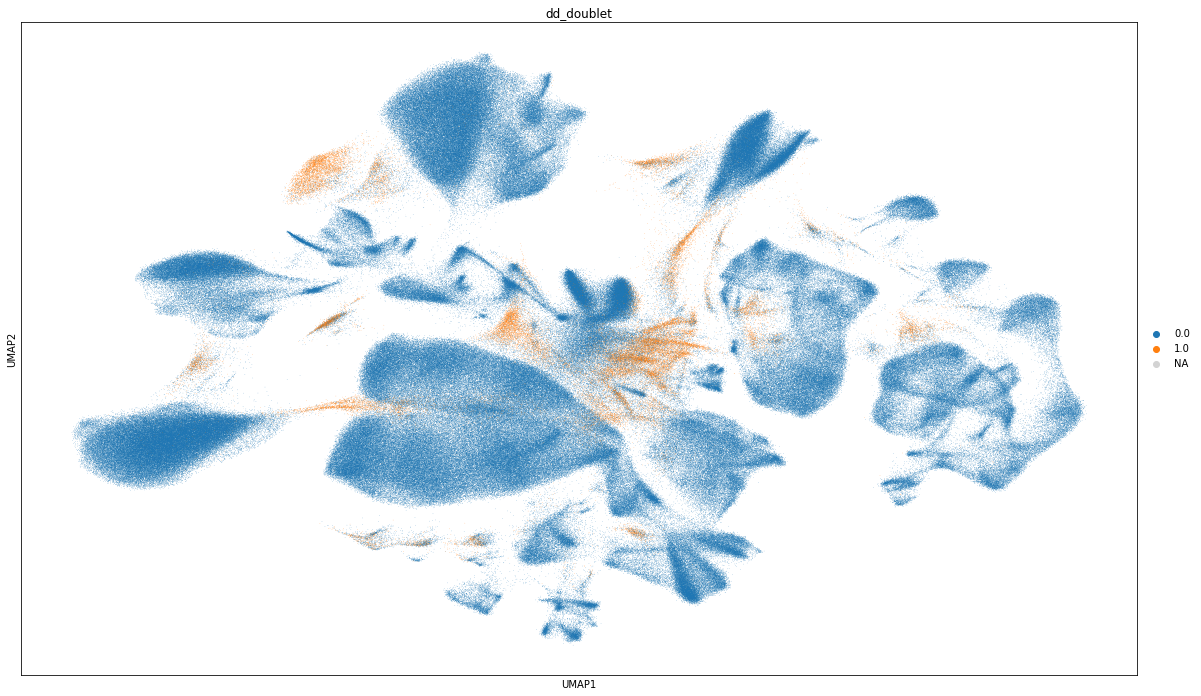

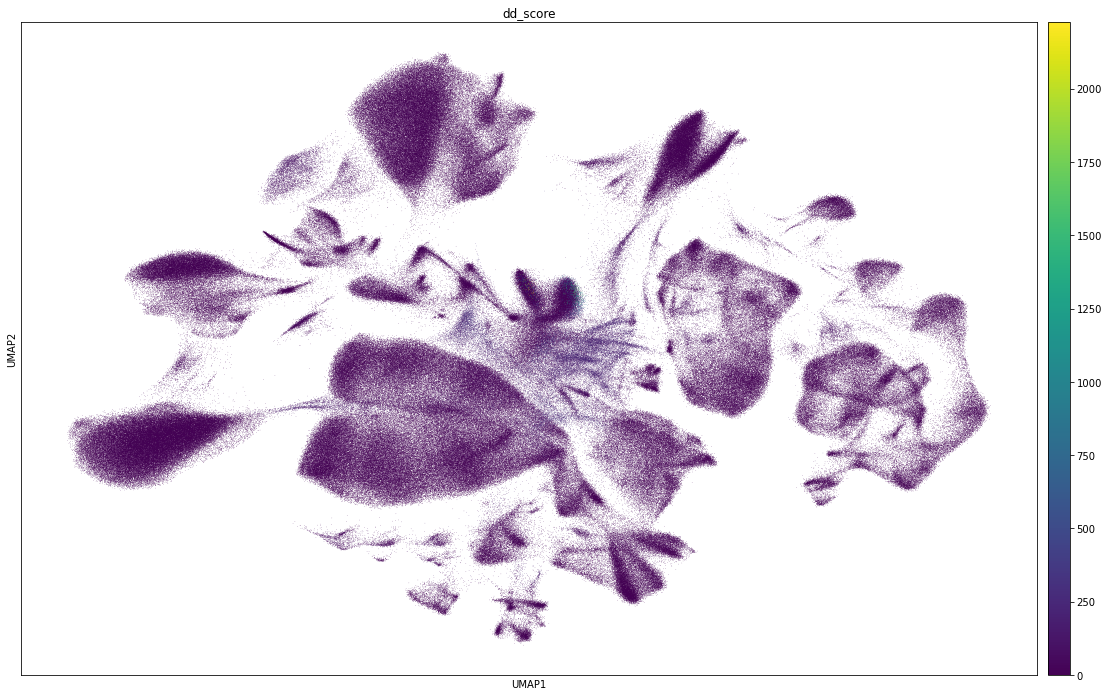

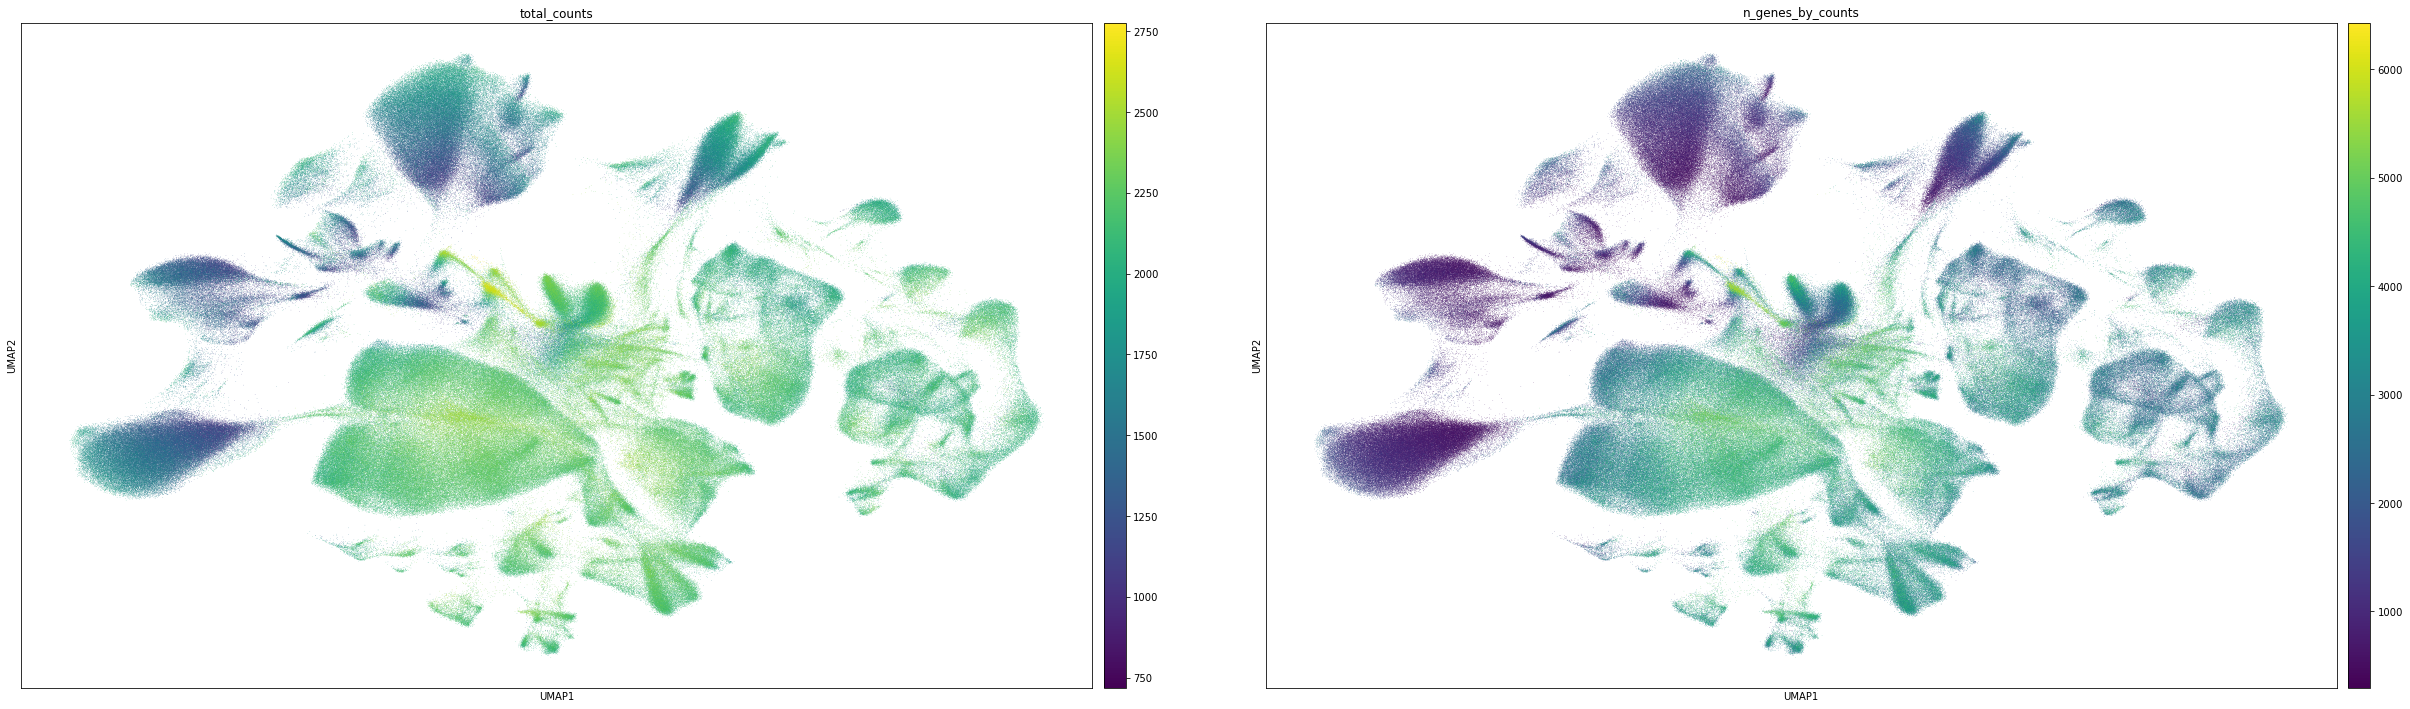

In [8]:
adata_dd.obs['dd_doublet'] = adata_dd.obs['dd_doublet'].astype('category')
sc.pl.umap(adata_dd, color="dd_doublet", size=800000 /adata_dd.n_obs)
sc.pl.umap(adata_dd, color="dd_score", size=800000 /adata_dd.n_obs)
sc.pl.umap(adata_dd, color=['total_counts', 'n_genes_by_counts'], size=800000 /adata_dd.n_obs)

## 2.2 Distribution of doublets over samples

In [ ]:
adata_dd_doublet = adata_dd[adata_dd.obs["dd_doublet"] == 1.0]

doublets_per_sample = adata_dd_doublet.obs.value_counts(["individual", "6-Batch"]).reset_index(name='counts')
doublets_per_sample = doublets_per_sample.drop_duplicates().sort_values(by='6-Batch')
print(doublets_per_sample)

plt.rcParams['figure.figsize']=(12,12)
plt.figure()
sb.set_theme(style="whitegrid")
doublets_plot = sb.displot(doublets_per_sample, x = 'counts')
doublets_plot.set(xlabel='Doublets per individual')

plt.rcParams['figure.figsize']=(16,6)
plt.figure()
sb.set_theme(style="whitegrid")
ax = sb.barplot(x = 'individual', y = 'counts', data = doublets_per_sample, hue = '6-Batch', 
                    dodge=False, order=doublets_per_sample['individual'], palette = sb.color_palette("Spectral", 16))
l = ax.set(xlabel='SU Number')
l = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

# 3. Filter out doublets

In [10]:
adata_dd = adata_dd[adata_dd.obs["dd_doublet"] == 0.0]

In [11]:
adata_dd

View of AnnData object with n_obs × n_vars = 850720 × 26182
    obs: 'sample', 'individual', 'region', 'experiment', 'batch', 'SU.Number', 'Age', 'AgeBin', 'Sex', 'Ethnic.origin', 'Status', 'Classification', 'Classification.detail', 'Trauma.Code', 'Trauma.notes.medical.history', 'PMI', 'Hemisphere', 'Brain.pH', 'RIN', 'Chlorpromazine.equivalent', 'Antidepressants', 'Mode.of.death', 'Manner.of.Death', 'Suicide', 'COD.category', 'positive.Toxicology', 'Antipsychotics', 'Duration.of.psych.illness', 'Antipsychotics.meds.pres', 'Smoking.status', 'Freezer.storage.time..days.', 'alcohol.intake..g.day.past.12.mth.', 'Age.of.onset', 'Agonal.score', 'Main.Batch', '6-Batch', 'Position', 'Group', 'Operator', 'aaa', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts',

In [12]:
# Save data to file
adata_dd.write(p['writedir']+'adata_qc_RNA_downsampling_perCell_filtDoublets.h5ad')